## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [11]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None, data_path='hotdog_nothotdog', processor=None):
        self.transform = transform
        self.processor = processor
        data_path = os.path.join(data_path, 'train' if train else 'test')
        
        # Get class names
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: idx for idx, c in enumerate(image_classes)}
        
        # Get image paths
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Apply processor normalization if given
        if self.processor:
            # processor expects PIL Image, but we already applied transforms.
            # If using transforms.ToTensor(), you can manually normalize
            # Here, we convert to a tensor and normalize
            image = self.processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Get label
        class_name = os.path.split(os.path.split(image_path)[0])[1]
        label = self.name_to_label[class_name]

        return {"pixel_values": image, "labels": label}


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 224
# train_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor()])

# a possibly better version of the train_transform
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path='hotdog_nothotdog')
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path='hotdog_nothotdog')
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [5]:
len(trainset), len(testset)

(2047, 1862)

In [15]:
trainset[100][0].shape

torch.Size([3, 128, 128])

Let's look at some images from our data 

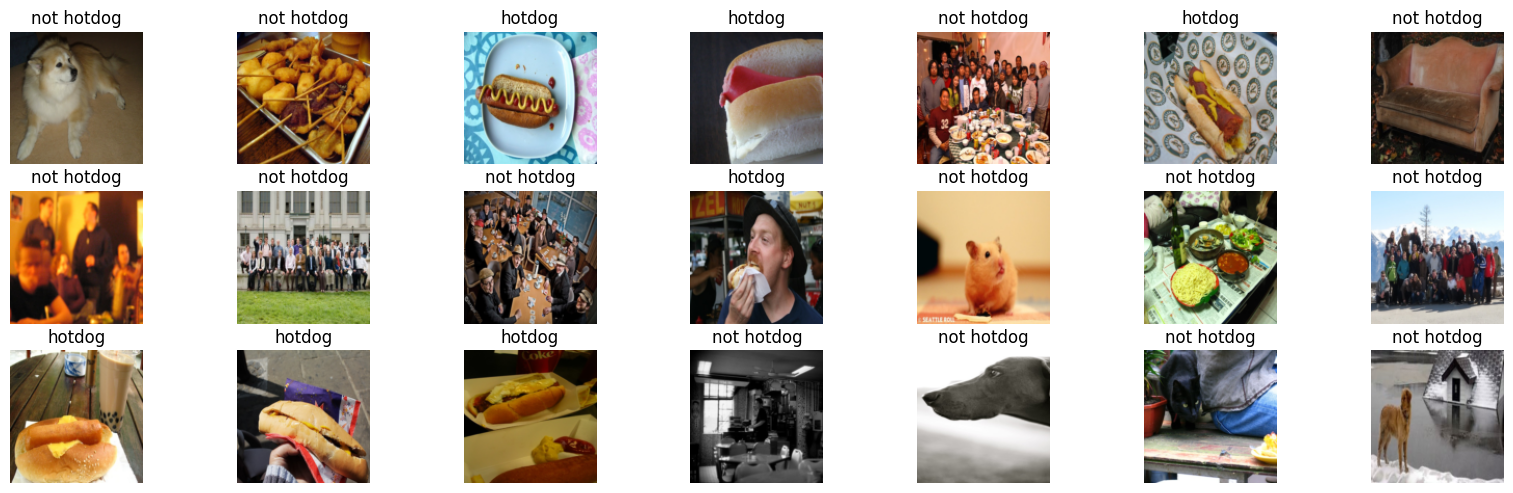

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):

    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


### Transfer Learning
Using the `nateraw/food` model from Hugging Face (https://huggingface.co/nateraw/food). This model follows the ResNet50 architecture (50 fully connected convolutional layers) and is pre-trained on ImageNet and then fine-tuned on Food-101, a benchmark dataset containing 101,000 food images including hotdogs. ImageNet is a general image dataset containing more than 14 mio. images in total. Models trained on ImageNet learn very general features such as edges, textures, colors in early layers and more complex shapes/objects in deeper layers. 

In [ ]:
# Load processor (handles resizing, normalization, etc.)
processor = AutoImageProcessor.from_pretrained("nateraw/food")

# Load model
pre_trained_model = AutoModelForImageClassification.from_pretrained("nateraw/food", num_labels=2, ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at nateraw/food and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([101, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([101]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing layers, except last 2 transformer blocks (optional):

In [ ]:
# Unfreeze last 2 transformer blocks
# for i, block in enumerate(pre_trained_model.base_model.encoder.layer):
#     if i >= 10:  
#         for param in block.parameters():
#             param.requires_grad = True

# # Also make sure classifier is trainable
# for param in pre_trained_model.classifier.parameters():
#     param.requires_grad = True

Function to compute test accuracy:

In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

Training (fine-tuning) the pre-trained model on the hotdog dataset:

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,  
    per_device_train_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=pre_trained_model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset=testset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

trainer.train()

c:\Users\sebas\.conda\envs\LSDA\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/320 [00:00<?, ?it/s]

2025/09/20 21:41:48 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 7667ccd865f64e84959a4b82d5749cbb: Failed to log run data: Exception: Changing param values is not allowed. Param with key='logging_dir' was already logged with value='./results\runs\Sep20_21-37-16_Kværneren' for run ID='7667ccd865f64e84959a4b82d5749cbb'. Attempted logging new value './results\runs\Sep20_21-41-47_Kværneren'.


  0%|          | 0/233 [00:00<?, ?it/s]

{'eval_loss': 0.08984681218862534, 'eval_accuracy': 0.9720730397422127, 'eval_runtime': 312.8869, 'eval_samples_per_second': 5.951, 'eval_steps_per_second': 0.745, 'epoch': 1.0}


  0%|          | 0/233 [00:00<?, ?it/s]

{'eval_loss': 0.08360161632299423, 'eval_accuracy': 0.9747583243823845, 'eval_runtime': 317.6651, 'eval_samples_per_second': 5.862, 'eval_steps_per_second': 0.733, 'epoch': 2.0}


  0%|          | 0/233 [00:00<?, ?it/s]

{'eval_loss': 0.07980141043663025, 'eval_accuracy': 0.976906552094522, 'eval_runtime': 316.4266, 'eval_samples_per_second': 5.884, 'eval_steps_per_second': 0.736, 'epoch': 3.0}


  0%|          | 0/233 [00:00<?, ?it/s]

{'eval_loss': 0.08271147310733795, 'eval_accuracy': 0.976906552094522, 'eval_runtime': 341.7021, 'eval_samples_per_second': 5.449, 'eval_steps_per_second': 0.682, 'epoch': 4.0}


  0%|          | 0/233 [00:00<?, ?it/s]

{'eval_loss': 0.08471672981977463, 'eval_accuracy': 0.976906552094522, 'eval_runtime': 320.9702, 'eval_samples_per_second': 5.801, 'eval_steps_per_second': 0.726, 'epoch': 5.0}
{'train_runtime': 7145.1756, 'train_samples_per_second': 1.432, 'train_steps_per_second': 0.045, 'train_loss': 0.042699497938156125, 'epoch': 5.0}


TrainOutput(global_step=320, training_loss=0.042699497938156125, metrics={'train_runtime': 7145.1756, 'train_samples_per_second': 1.432, 'train_steps_per_second': 0.045, 'total_flos': 7.931305137053491e+17, 'train_loss': 0.042699497938156125, 'epoch': 5.0})

Showing a few misclassified images:

In [ ]:
y_true = []
y_pred = []
misclassified = []

pre_trained_model.eval()
for i in range(len(testset)):
    sample = testset[i]
    img = sample["pixel_values"].unsqueeze(0).to(device)
    label = sample["labels"]
    with torch.no_grad():
        output = pre_trained_model(img)
        logits = output.logits if hasattr(output, "logits") else output
        pred = logits.argmax(1).item()
    if pred != label:
        misclassified.append((img.cpu(), label, pred, i))
    y_true.append(label)
    y_pred.append(pred)

# Show up to 5 misclassified images
plt.figure(figsize=(15, 3))
for idx, (img, label, pred, i) in enumerate(misclassified[:5]):
    plt.subplot(1, 5, idx+1)
    img_np = img.squeeze().numpy().transpose(1, 2, 0)
    plt.imshow(img_np)
    plt.title(f"True: {['hotdog','not hotdog'][label]}\nPred: {['hotdog','not hotdog'][pred]}")
    plt.axis('off')
plt.show()
# ...existing code...

Computing and plotting the confusion matrix:

In [ ]:
# computing confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hotdog', 'not hotdog'])

# plotting the confusion matrix
plt.figure(figsize=(5,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()